In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
import warnings
warnings.filterwarnings('ignore')

In [14]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [15]:
df = pd.read_csv("/Users/jedapa/Desktop/spx.csv",parse_dates=['Date'], index_col='Date')
df

,SPX
Date,
1990-02-01,328.79
1990-02-02,330.92
1990-02-05,331.85
1990-02-06,329.66
1990-02-07,333.75
...,...
2011-10-10,1194.89
2011-10-11,1195.54
2011-10-12,1207.25


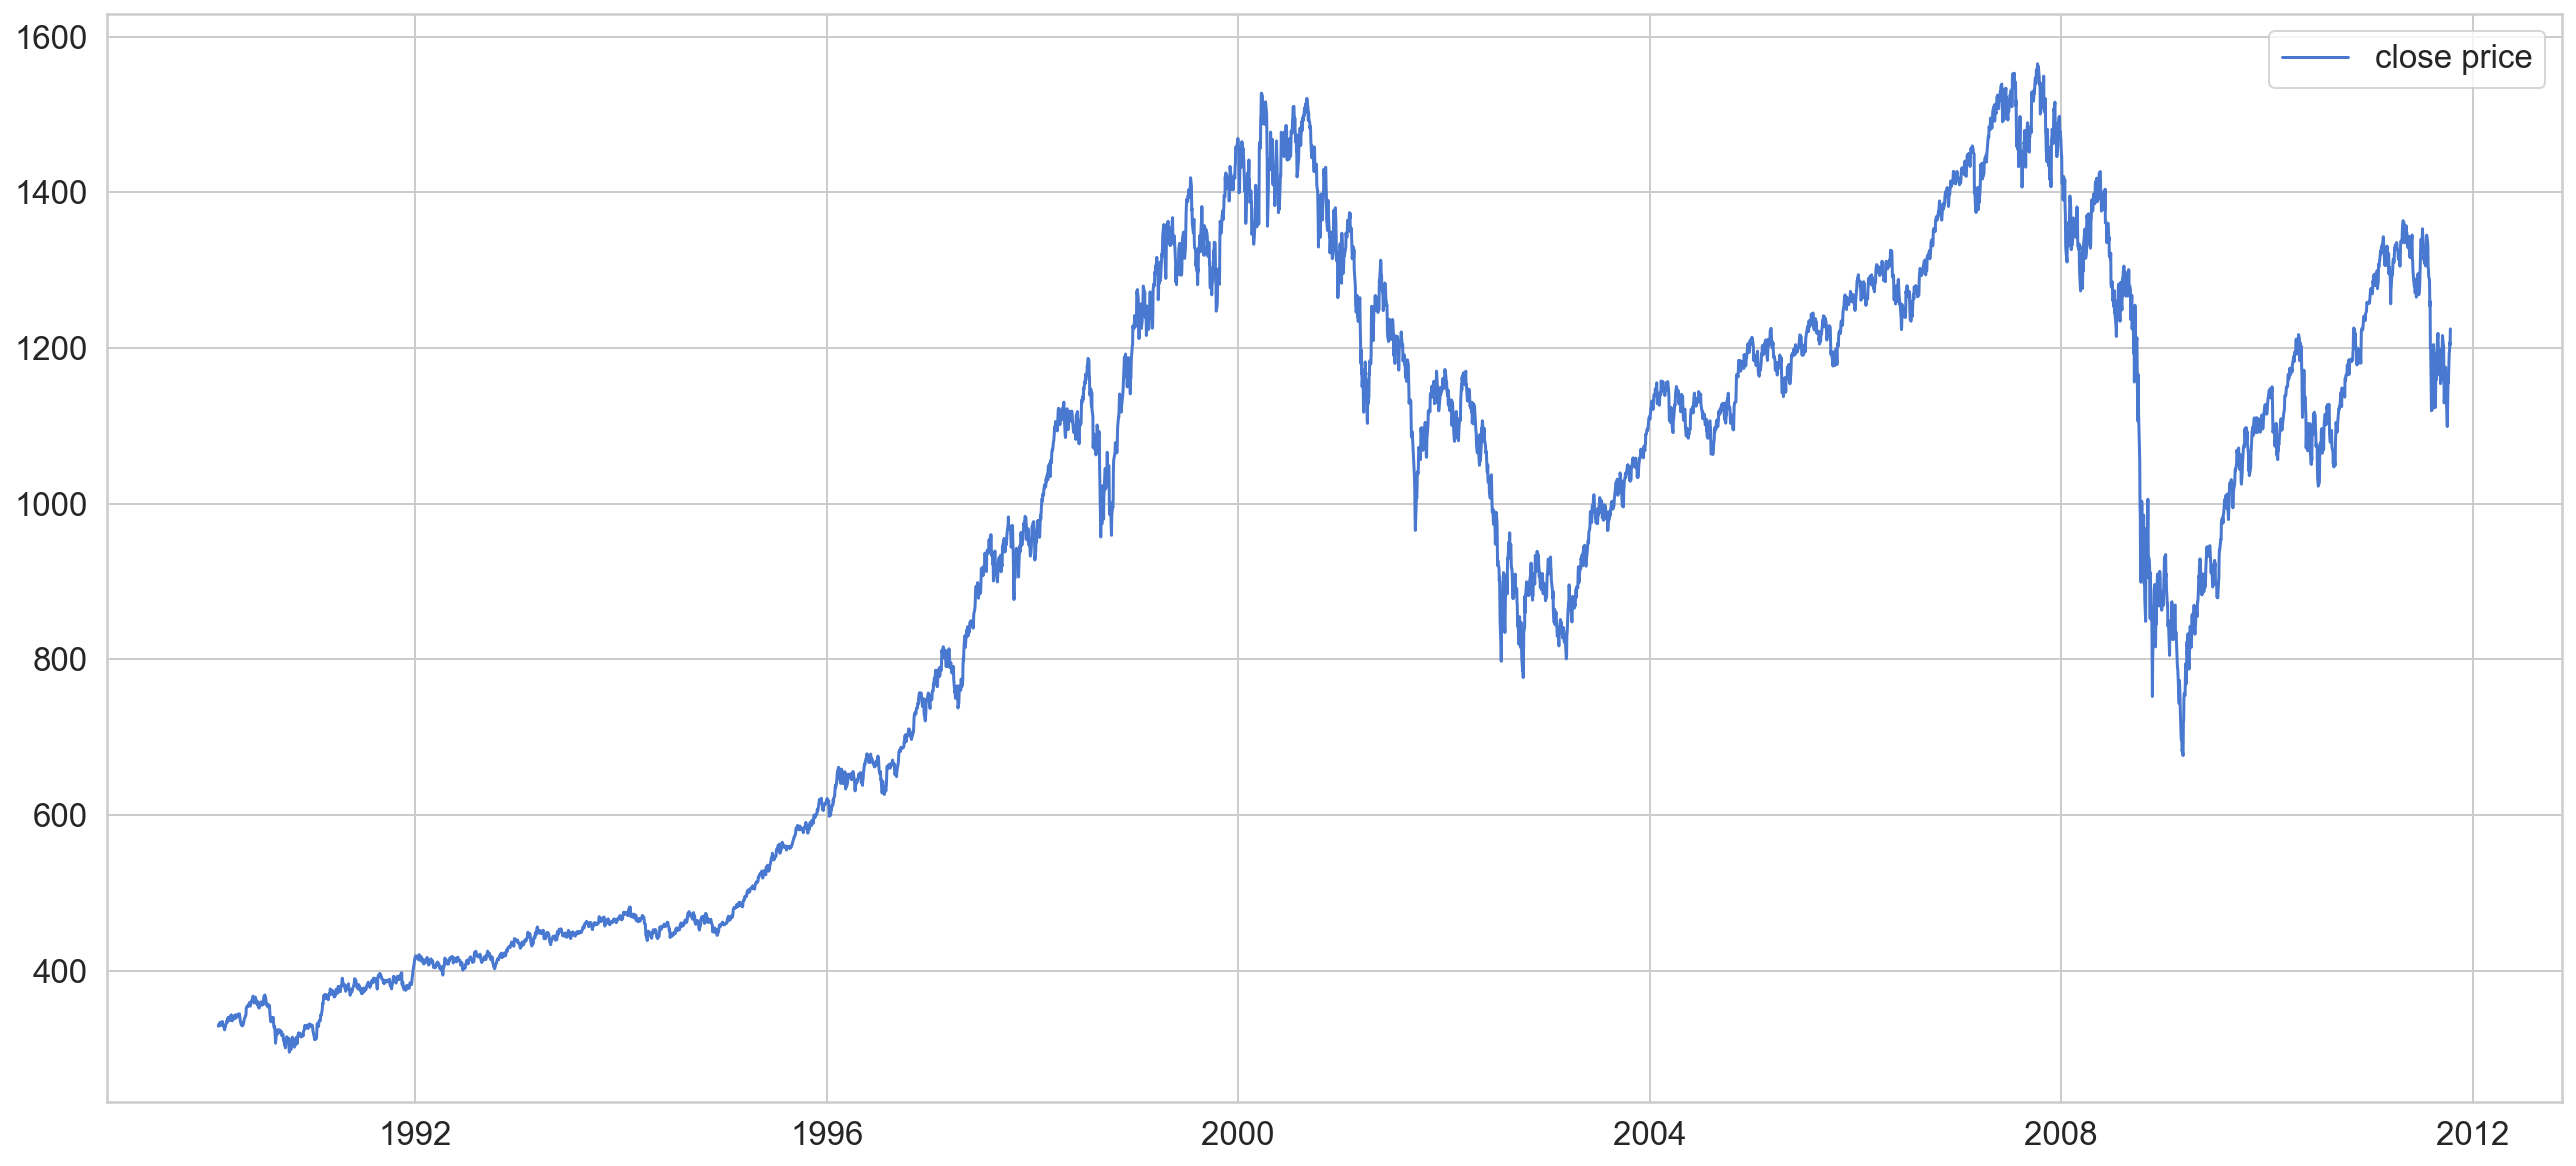

In [16]:
plt.plot(df, label='close price')
plt.legend();

In [17]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5198, 1) (274, 1)


In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['SPX']])

train['SPX'] = scaler.transform(train[['SPX']])
test['SPX'] = scaler.transform(test[['SPX']])

In [21]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [29]:
TIME_STEPS = 30 # Secuencia de 30 dias

X_train, y_train = create_dataset(train[['SPX']], train.SPX, TIME_STEPS)
X_test, y_test = create_dataset(test[['SPX']], test.SPX, TIME_STEPS)

X_train

array([[[-1.61420011],
        [-1.60846939],
        [-1.60596724],
        ...,
        [-1.59480175],
        [-1.59246103],
        [-1.58923246]],

       [[-1.60846939],
        [-1.60596724],
        [-1.6118594 ],
        ...,
        [-1.59246103],
        [-1.58923246],
        [-1.57890101]],

       [[-1.60596724],
        [-1.6118594 ],
        [-1.60085533],
        ...,
        [-1.58923246],
        [-1.57890101],
        [-1.57454244]],

       ...,

       [[ 0.46502988],
        [ 0.53030093],
        [ 0.51577234],
        ...,
        [ 0.45768487],
        [ 0.47197132],
        [ 0.4864192 ]],

       [[ 0.53030093],
        [ 0.51577234],
        [ 0.5340138 ],
        ...,
        [ 0.47197132],
        [ 0.4864192 ],
        [ 0.51964663]],

       [[ 0.51577234],
        [ 0.5340138 ],
        [ 0.53016641],
        ...,
        [ 0.4864192 ],
        [ 0.51964663],
        [ 0.51749425]]])

In [30]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

In [31]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Train on 4651 samples, validate on 517 samples
Epoch 1/10
4651/4651 [==============================] - 24s 5ms/sample - loss: 0.2205 - val_loss: 0.1460
Epoch 2/10
4651/4651 [==============================] - 18s 4ms/sample - loss: 0.1356 - val_loss: 0.1046
Epoch 3/10
4651/4651 [==============================] - 19s 4ms/sample - loss: 0.1122 - val_loss: 0.1182
Epoch 4/10
4651/4651 [==============================] - 18s 4ms/sample - loss: 0.1053 - val_loss: 0.1295
Epoch 5/10
4651/4651 [==============================] - 18s 4ms/sample - loss: 0.1150 - val_loss: 0.1976
Epoch 6/10
4651/4651 [==============================] - 18s 4ms/sample - loss: 0.1443 - val_loss: 0.3128
Epoch 7/10
4651/4651 [==============================] - 17s 4ms/sample - loss: 0.1698 - val_loss: 0.3318
Epoch 8/10
4651/4651 [==============================] - 18s 4ms/sample - loss: 0.1765 - val_loss: 0.3299
Epoch 9/10
4651/4651 [==============================] - 17s 4ms/sample - loss: 0.1596 - val_loss: 0.2631
Epoch 10

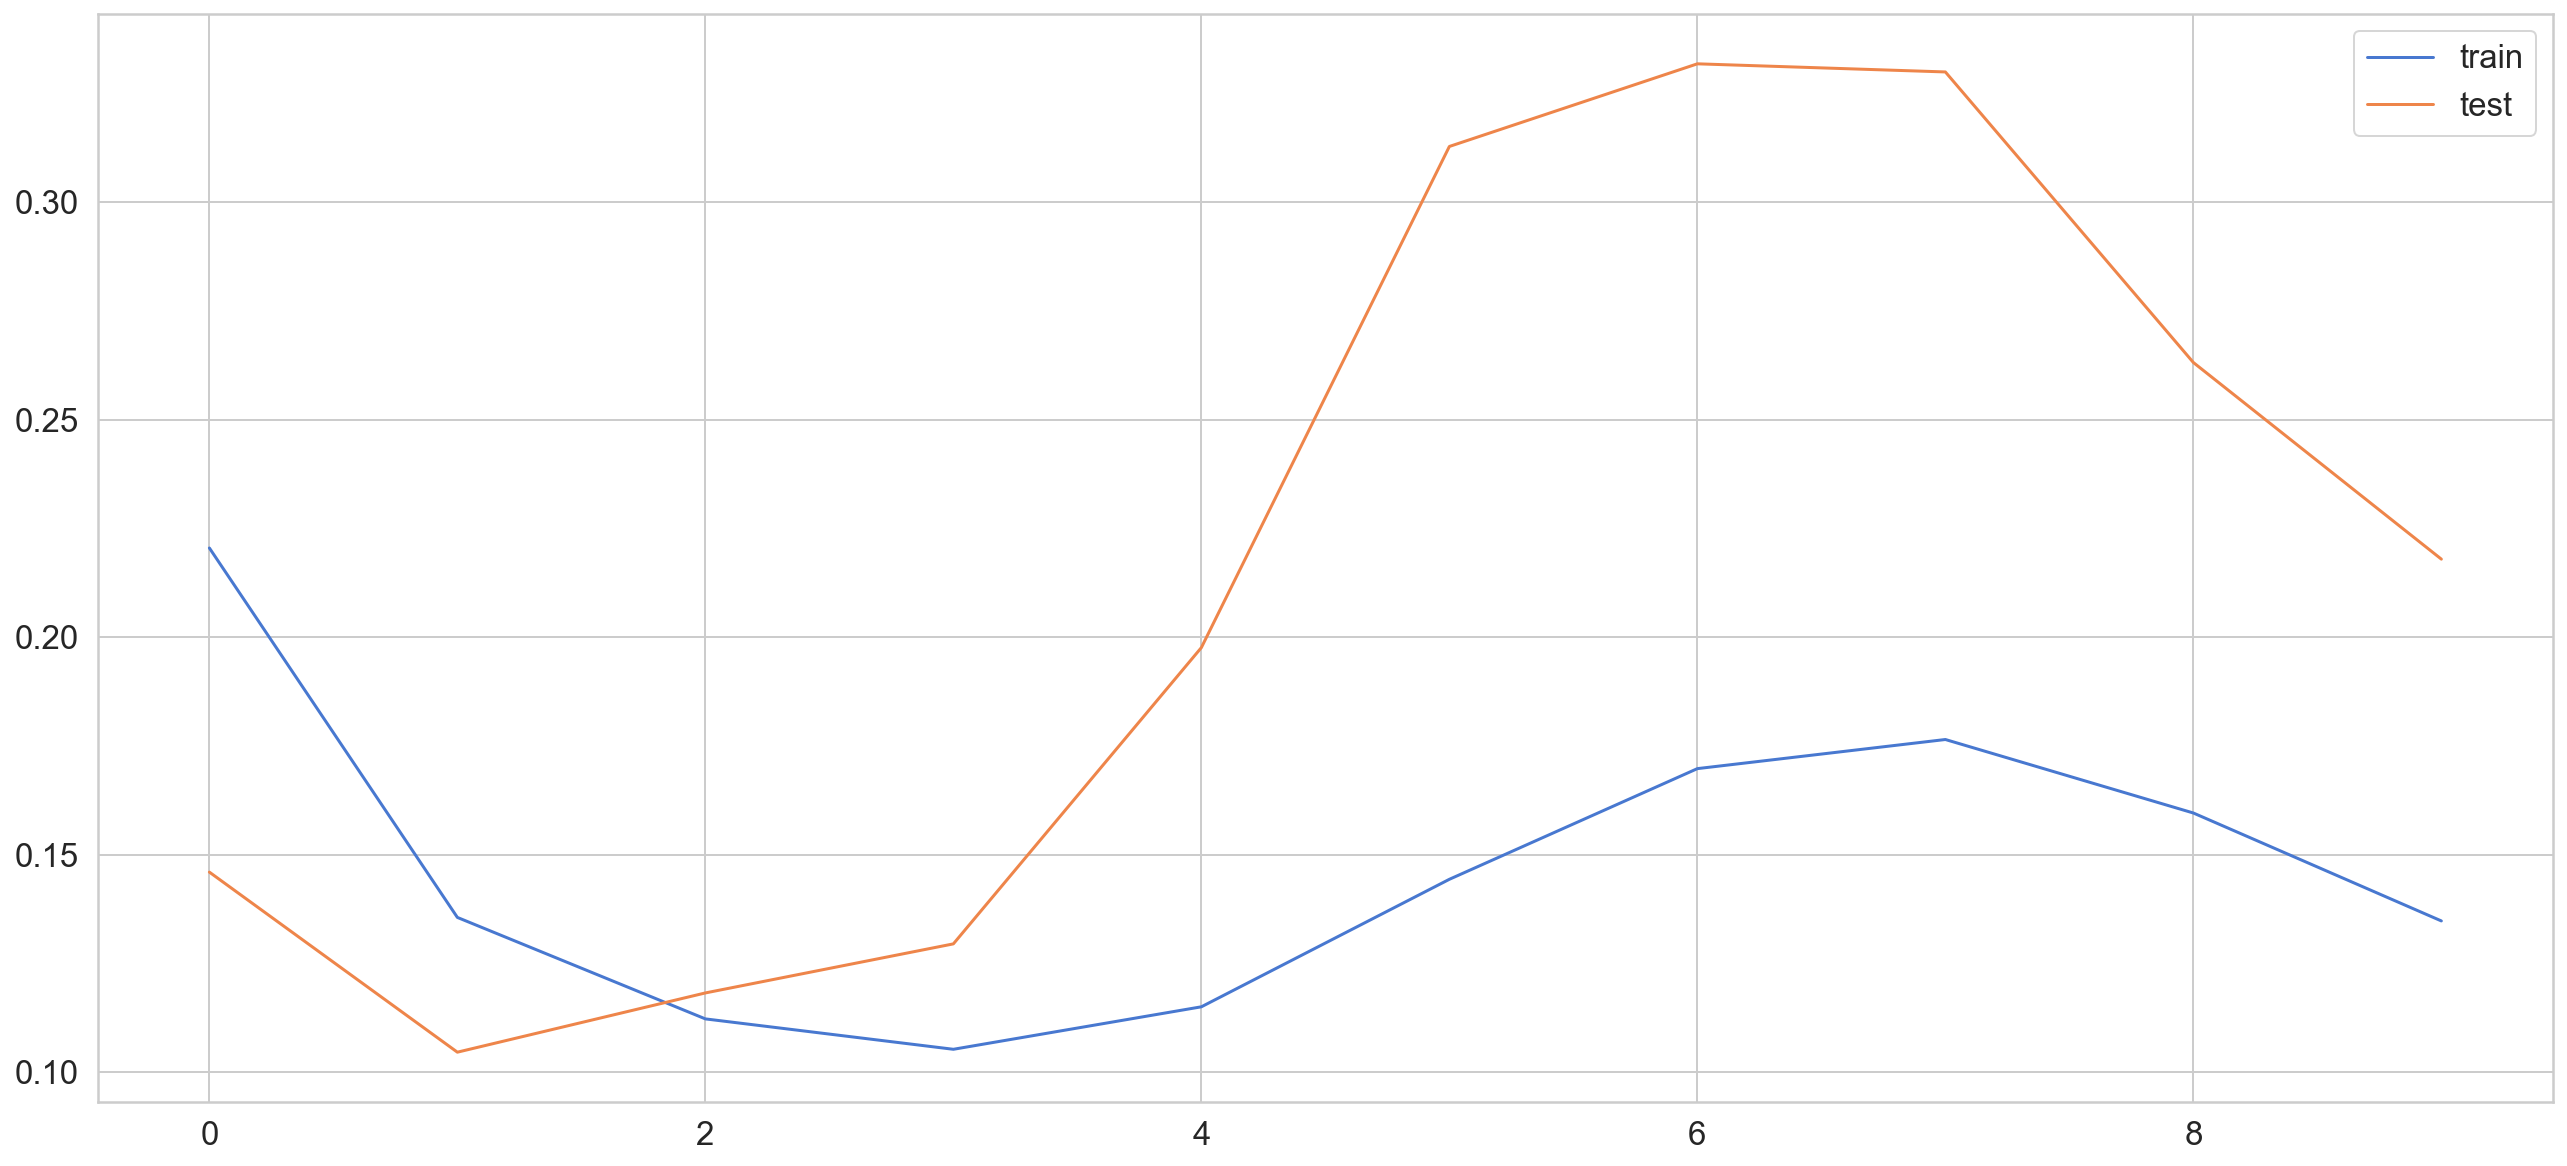

In [32]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

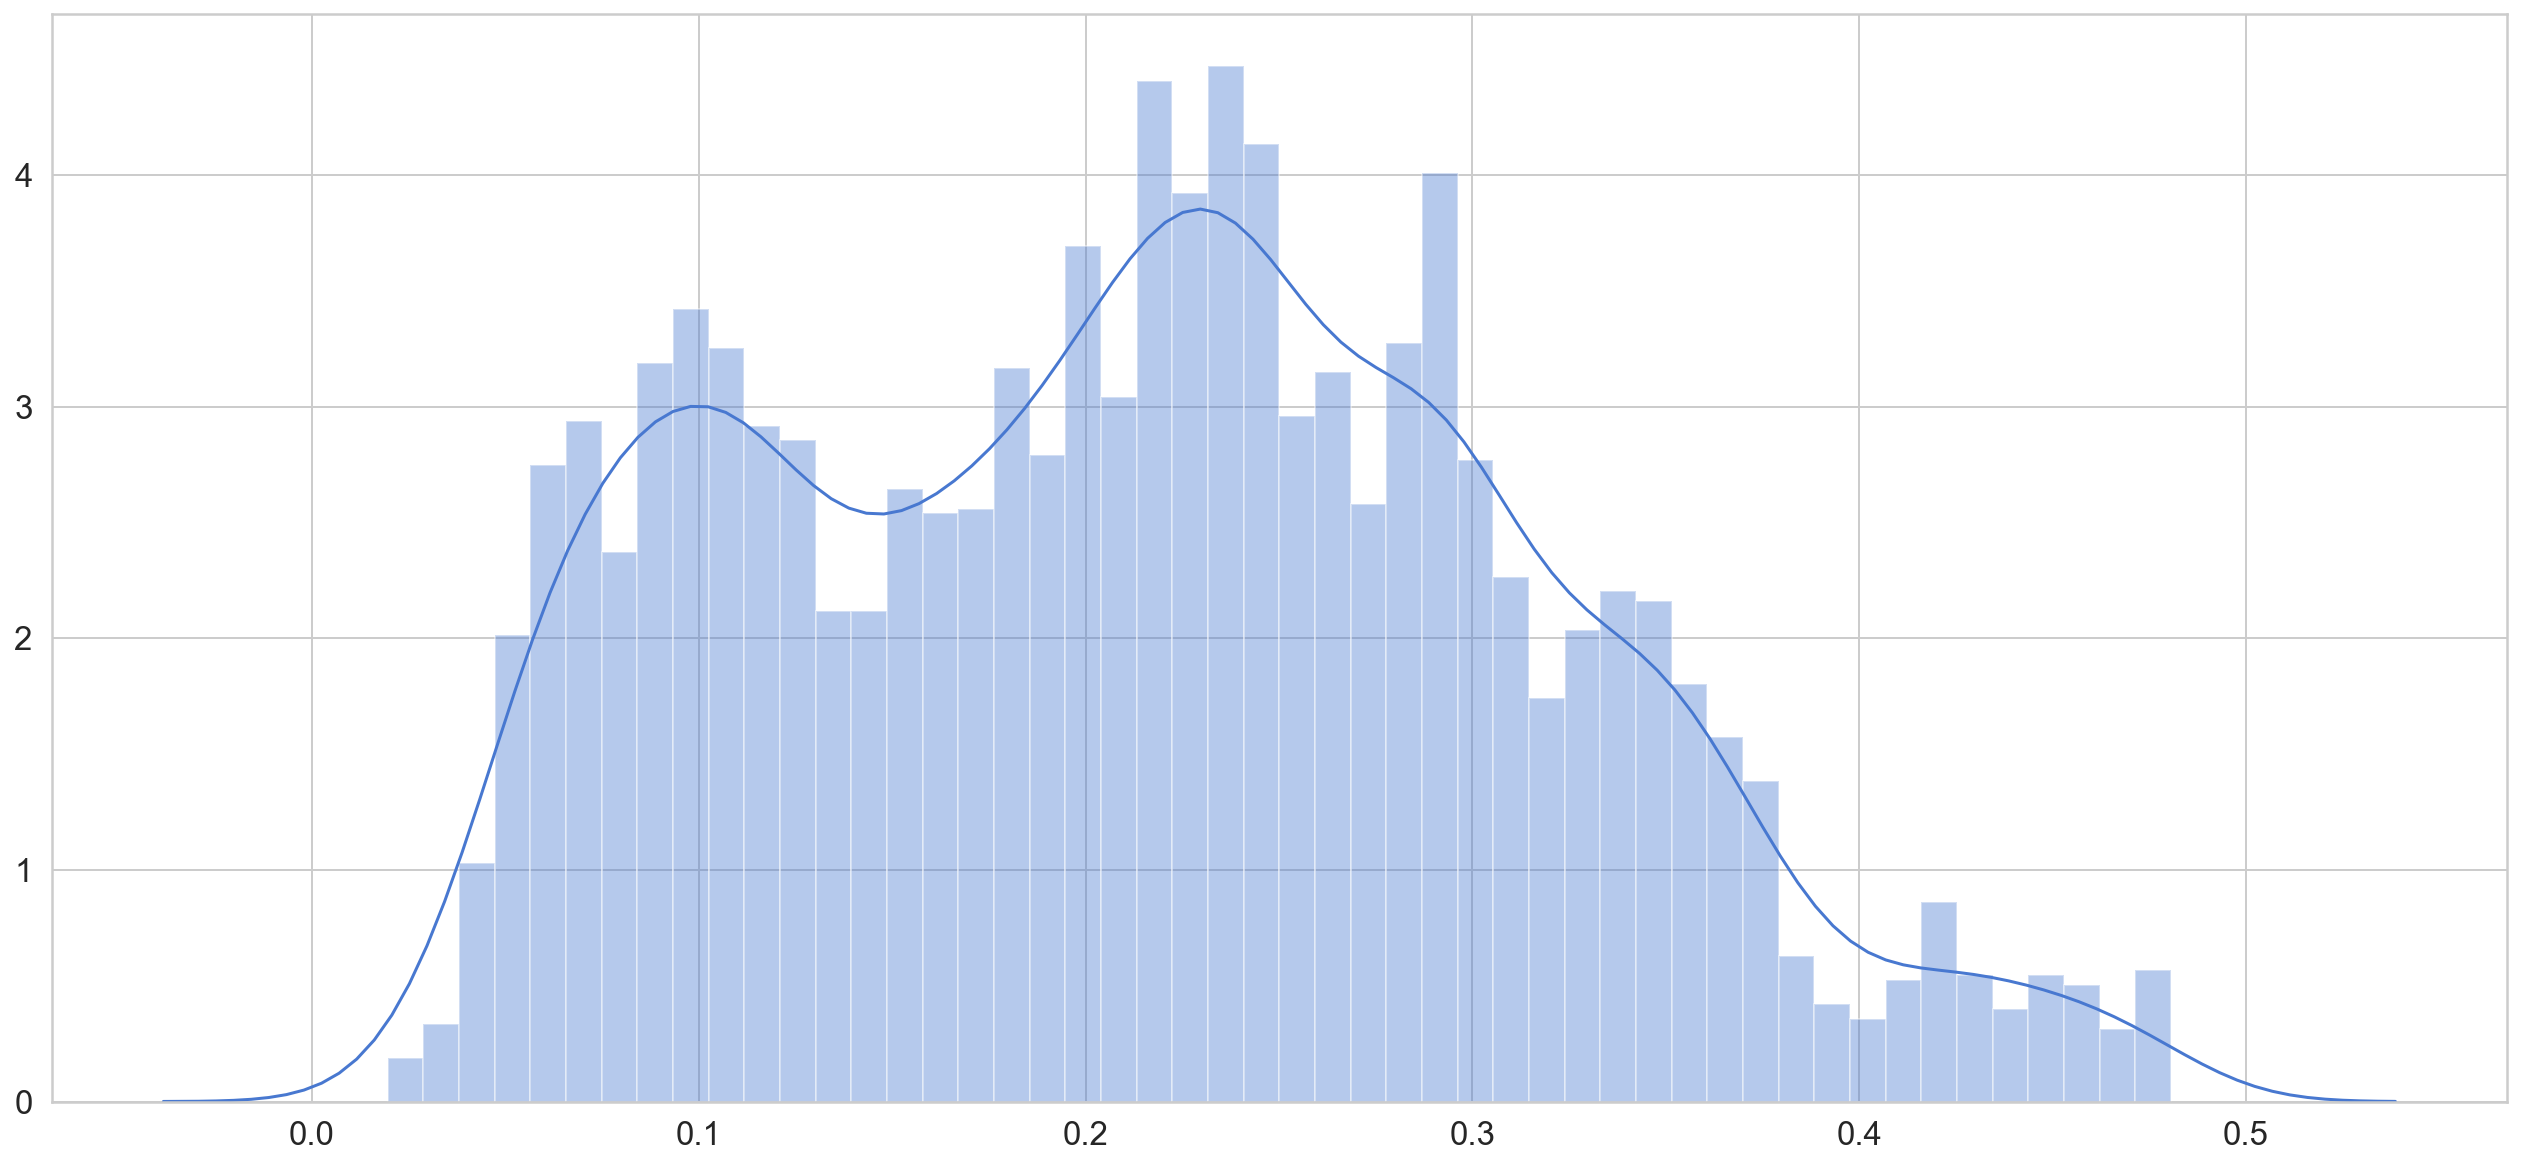

In [47]:
X_test_pred = model.predict(X_test)
#X_train_pred = model.predict(X_train)
#train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
sns.distplot(train_mae_loss, bins=50, kde=True);

In [52]:
THRESHOLD = 0.32

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['SPX'] = test[TIME_STEPS:].SPX

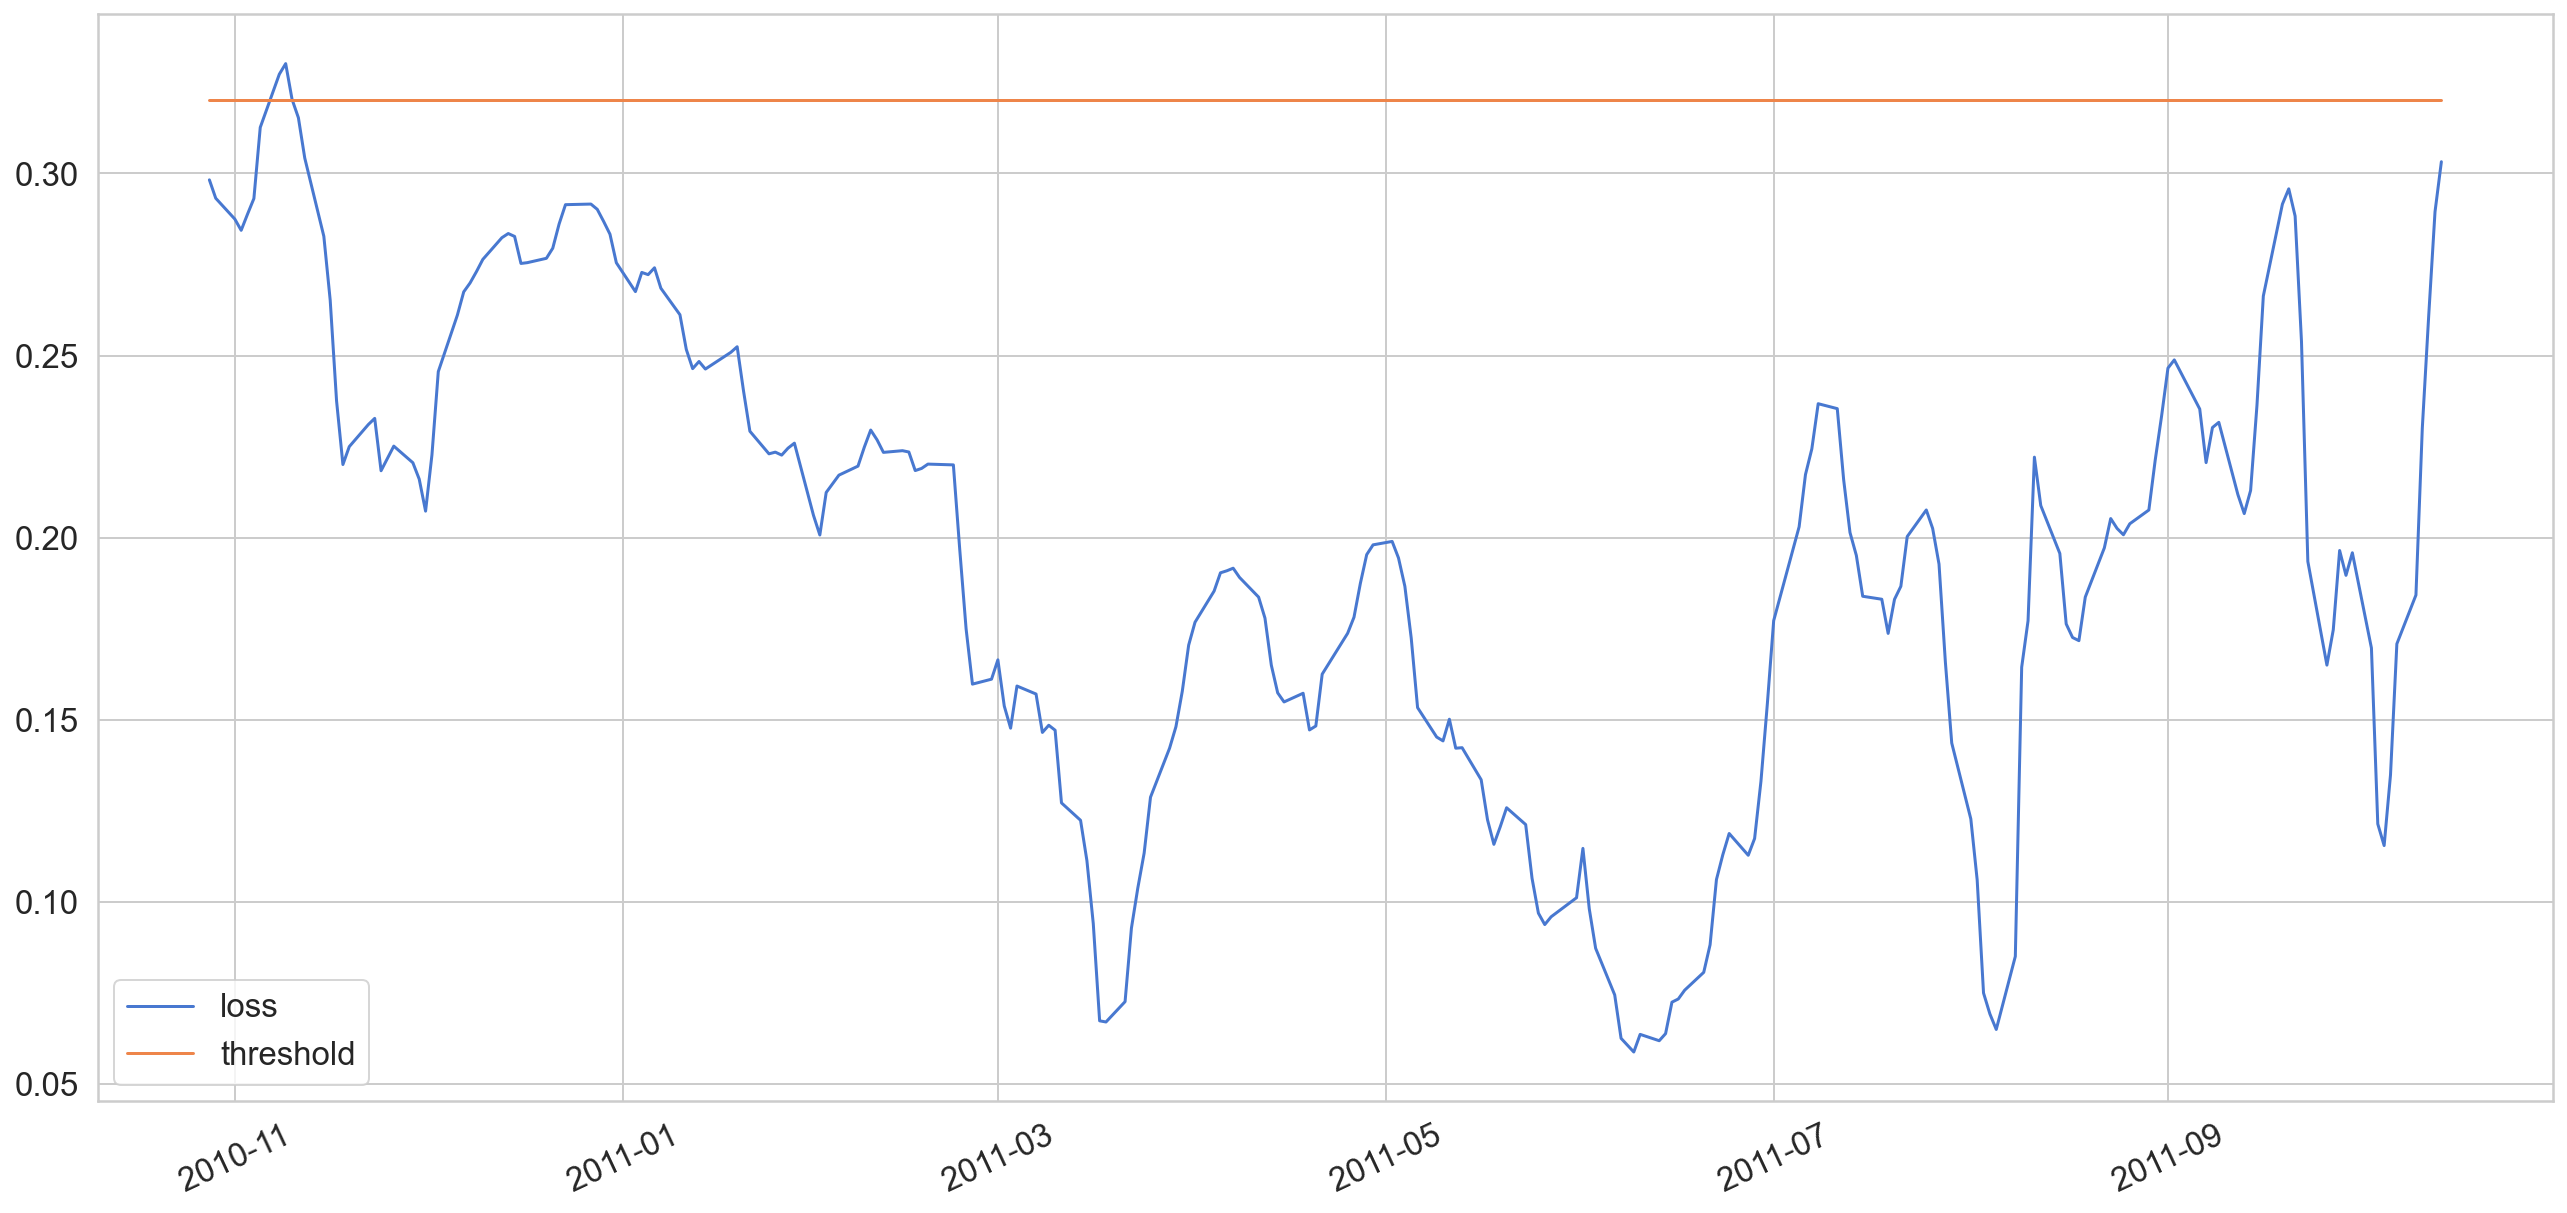

In [53]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();


In [54]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()


,loss,threshold,anomaly,SPX
Date,,,,
2010-11-08,0.327207,0.32,True,0.792327
2010-11-09,0.330107,0.32,True,0.765826
2010-11-10,0.320330,0.32,True,0.780112


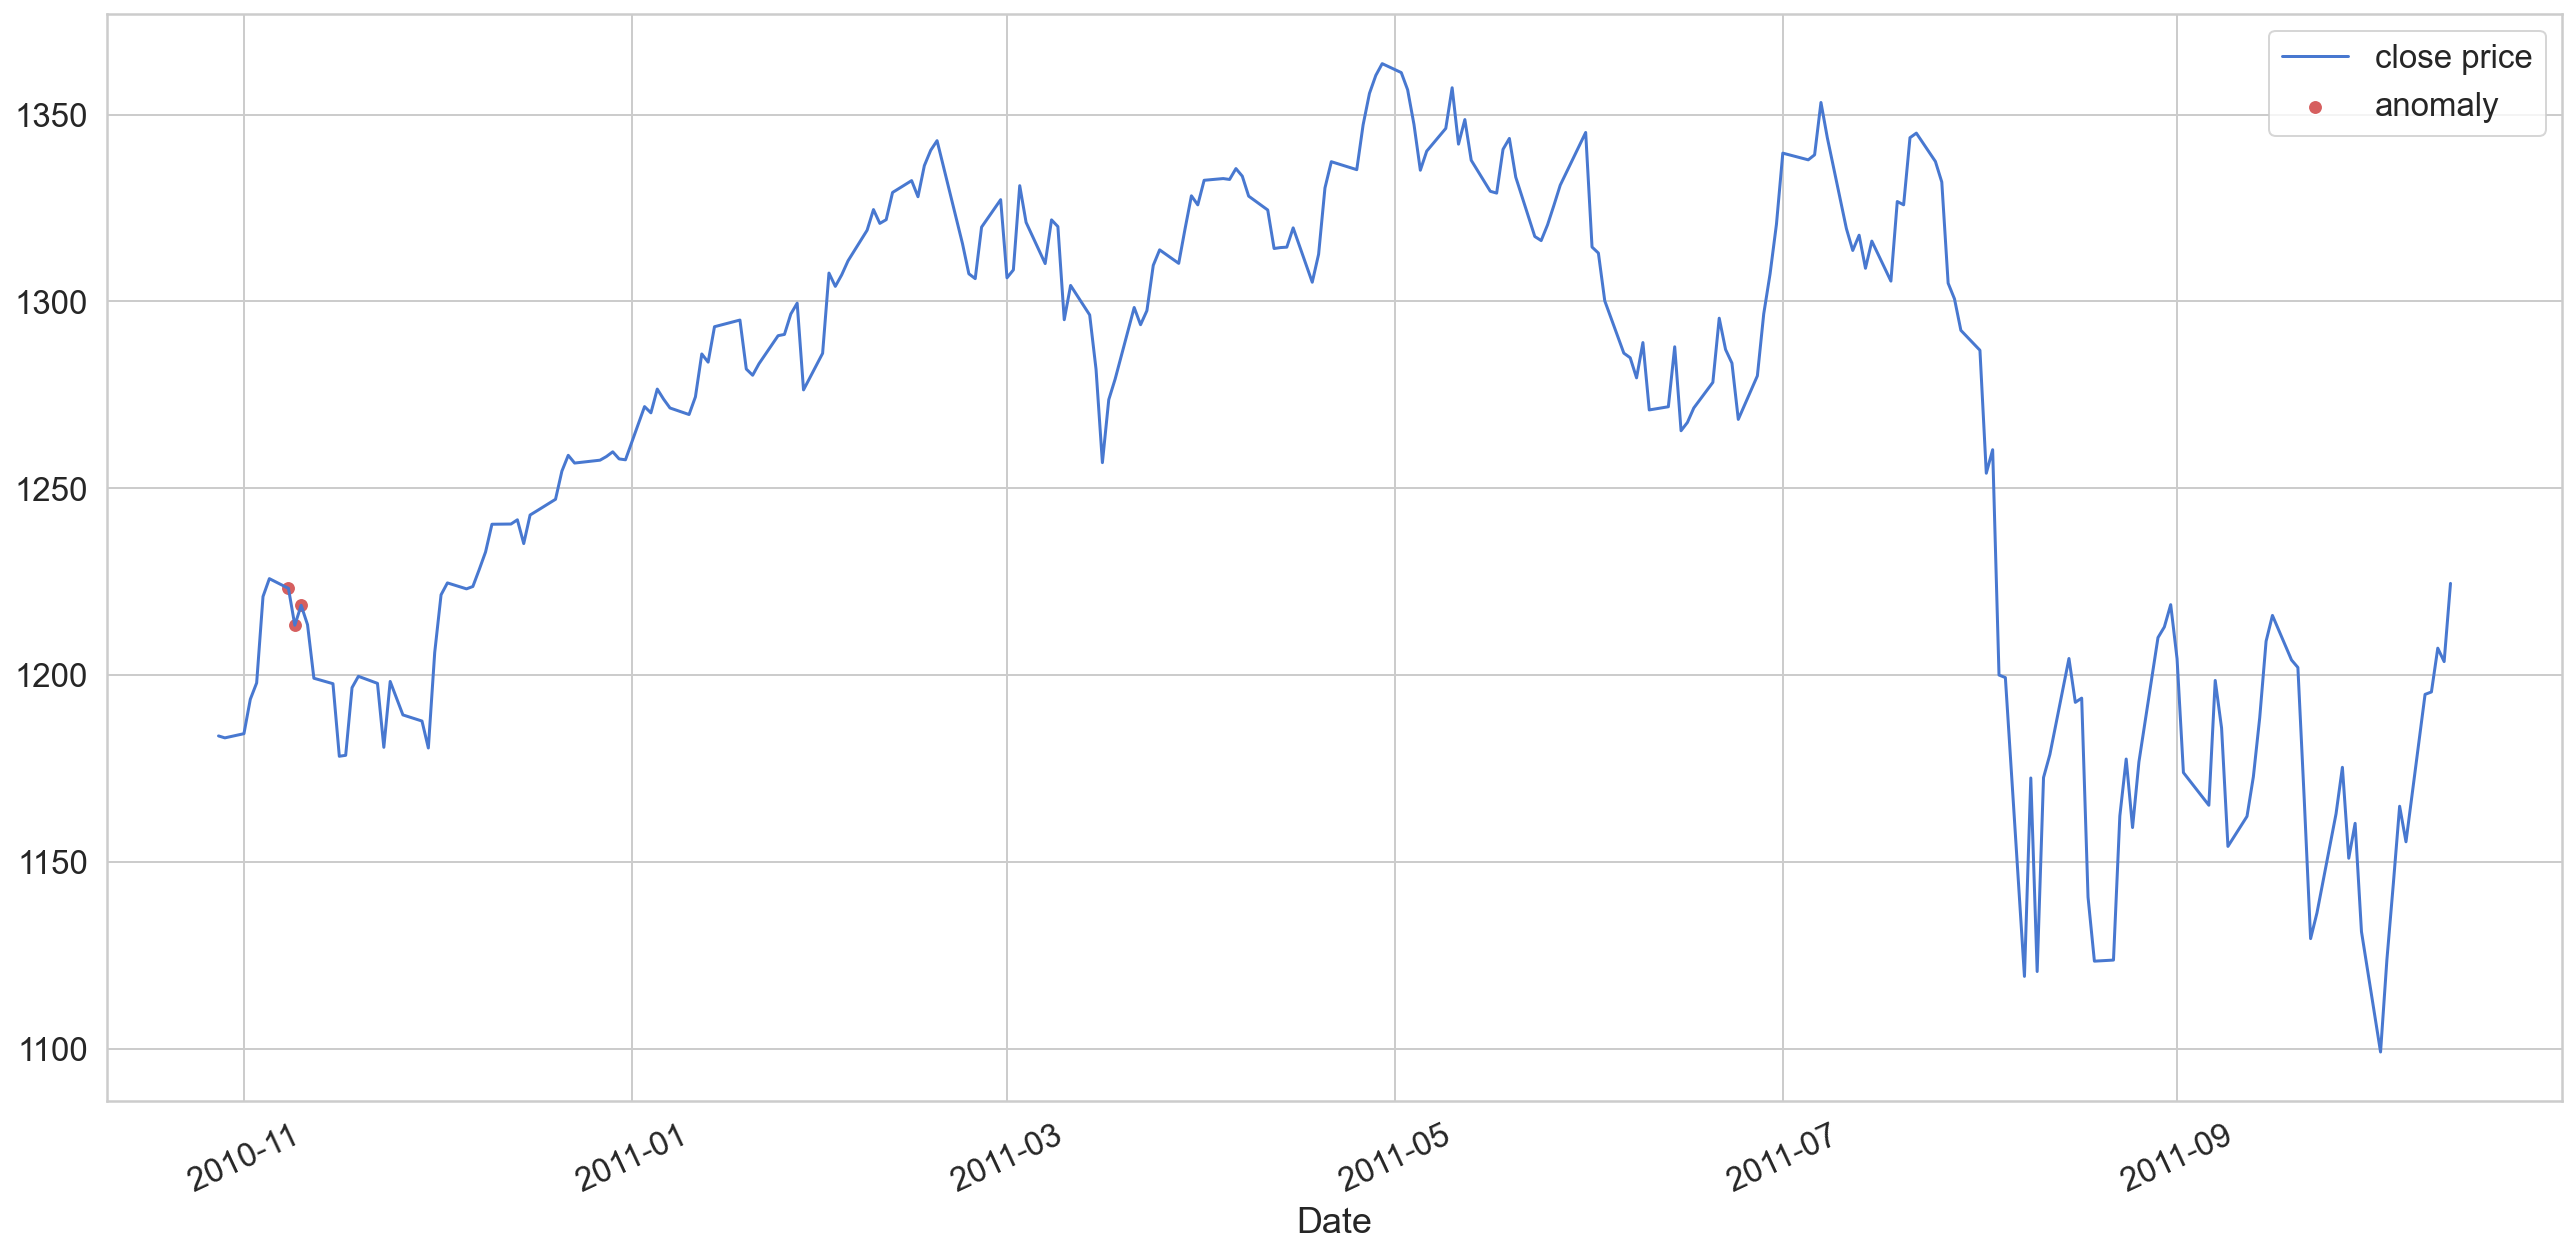

In [56]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].SPX), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.SPX),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();